# Курсовая работа Deep Learning

## Variant - 2 
### Исследование применимости автокодировщиков к решению задачи предсказания времени поломки оборудования.

#### Задача прогнозирования поломок имеет целью уменьшить риски использования неисправного оборудования, что позволит увеличить безопасность эксплуатации и снизить расходы. В процессе эксплуатации оборудования, как правило, производится периодический сбор различных параметров с помощью датчиков. Эти параметры могут использоваться для прогнозирования сроков службы. Вам предлагается применить нейросетевые модели автокодировщиков для оценки момента выхода оборудования из строя в предположении, что непосредственно перед поломкой показания датчиков становятся аномальными (и, следовательно, увеличивается ошибка реконструкции автокодировщика).

#### Выполнили: Захаров Д.А. Щукин А.А.
#### Группа ИВТ-360

### *Этап 1 - Установка библиотек*

In [1]:
import glob
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly as pl
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#%load_ext tensorboard
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
#   except RuntimeError as e:
#     print(e)

Num GPUs Available:  0


### *Этап 2 - Загрузка датасета*
*Загружаем только train, т.к. только в данных датасетах есть гарантия, что деталь вышла из строя*

In [39]:
X1 = pd.read_csv("C:/MyLabProjects/DeepLearning/Course_Work_DL/CMaps/Convret/train_FD001.csv")
X2 = pd.read_csv("C:/MyLabProjects/DeepLearning/Course_Work_DL/CMaps/Convret/train_FD002.csv")
X3 = pd.read_csv("C:/MyLabProjects/DeepLearning/Course_Work_DL/CMaps/Convret/train_FD003.csv")
X4 = pd.read_csv("C:/MyLabProjects/DeepLearning/Course_Work_DL/CMaps/Convret/train_FD004.csv")

*Объеденим данные по каждому объекту*

In [ ]:
# X1 = pd.concat([X1_test, X1_train])
# X2 = pd.concat([X2_test, X2_train])
# X3 = pd.concat([X3_test, X3_train])
# X4 = pd.concat([X4_test, X4_train])

In [3]:
X1

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## *Разведочный анализ данных*

### *Визуализируем данные с помощью метода t-SNE*

*t-SNE - (встраивание стохастических соседей с t-распределением) нелинейный метод уменьшения размерности данных. Метод неконтролируемого нелинейного уменьшения размерности. Нелинейное уменьшение размерности означает, что алгоритм позволяет нам разделить данные, которые нельзя разделить прямой линией.*

#### *Алгоритм t-SNE находит меру сходства между парами экземпляров в пространстве большей и меньшей размерности. После этого он пытается оптимизировать две меры сходства. Все это делается в три шага:*

    1.t-SNE моделирует точку, выбранную в качестве соседа другой точки как в более высоких, так и в более низких измерениях. Он начинается с вычисления попарного сходства между всеми точками данных в многомерном пространстве с использованием ядра Гаусса. Точки, которые находятся далеко друг от друга, имеют меньшую вероятность быть выбранными, чем точки, которые расположены близко друг к другу.

    2.Затем алгоритм пытается сопоставить точки данных более высокой размерности с пространством более низкой размерности, сохраняя при этом попарное сходство.

    3.Это достигается за счет минимизации расхождения между вероятностным распределением исходного высокоразмерного и низкоразмерного. Алгоритм использует градиентный спуск, чтобы минимизировать расхождение. Вложение более низкой размерности оптимизируется до стабильного состояния.

#### *Процесс оптимизации позволяет создавать кластеры и подкластеры похожих точек данных в пространстве более низкого измерения, которые визуализируются для понимания структуры и взаимосвязи в данных более высокого измерения.*

In [ ]:
# X1emb = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X1)

In [ ]:
# X1emb_pd = pd.DataFrame(X1emb)
# X1emb_pd

In [ ]:
# X1emb_pd.columns = ['col1', 'col2', 'col3']
# X1emb_pd

In [ ]:
# fig1 = go.Scatter3d(x = X1emb_pd['col1'], y = X1emb_pd['col2'], z = X1emb_pd['col3'], 
#                                                                                     marker=dict(opacity=0.9,
#                                                                                     reversescale=True,
#                                                                                     colorscale='Blues',
#                                                                                     size=5),
#                                                                                     line=dict (width=0.02), 
#                                                                                     mode = 'markers')

# mylayout = go.Layout(scene=dict(xaxis = dict(title = "col1"), yaxis = dict(title = "col2"), zaxis = dict(title = "col3")))

# pl.offline.plot({"data": [fig1], "layout": mylayout}, auto_open = True)

'temp-plot.html'

### *Попытки представить данные в виде 3х-мерных графиков*
*Operational settings (3 столбца) будем изображать на графике с помощью форм (круг, квадрат, треугольник соответствено), тем самым отображая 3 измерения в 1*

In [ ]:
markersize = X1['operational setting 1'] + 10
markercolor = (X1['operational setting 2'] + 0.005) * 1000
#markershape = X1['operational setting 3'].replace("square")

fig1 = go.Scatter3d(x = X1['unit number'], y = X1['time in cycles'], z = X1['sensor measurement 7'],
                                                                                    marker=dict(size=markersize,
                                                                                                                color = markercolor,
                                                                                                                #symbol = markershape,
                                                                                                                opacity = 0.9,
                                                                                                                reversescale = True,
                                                                                                                colorscale = 'Blues'),
                                                                                    line=dict(width=0.02), 
                                                                                    mode = 'markers')

mylayout = go.Layout(scene=dict(xaxis = dict(title = "unit number"), yaxis = dict(title = "time in cycles"), zaxis = dict(title = "sensor measurement")))

pl.offline.plot({"data": [fig1], "layout": mylayout}, auto_open = True)

'temp-plot.html'

### *Представим данные отдельных столбцов в виде графиков*

#### *Time in cycles*

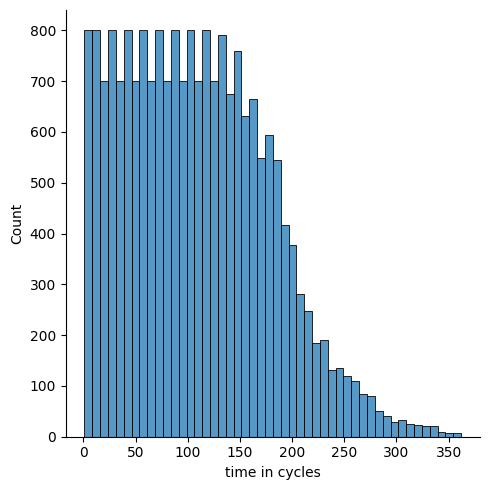

In [4]:
# X1_train["time in cycles"].hist(bins=50)
sns.displot(X1["time in cycles"])

#### *Operational settings [1 - 3]*

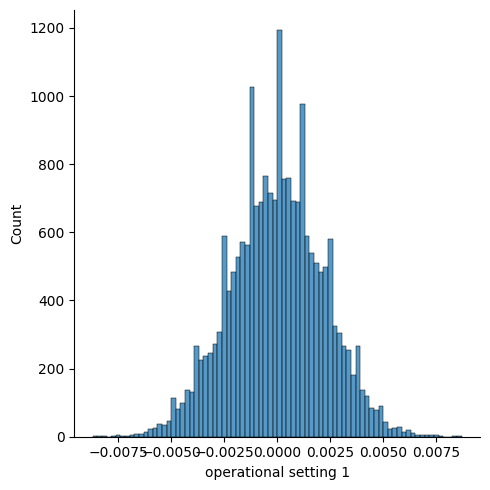

In [5]:
# X1_train["operational setting 1"].hist(bins=50)
sns.displot(X1["operational setting 1"])

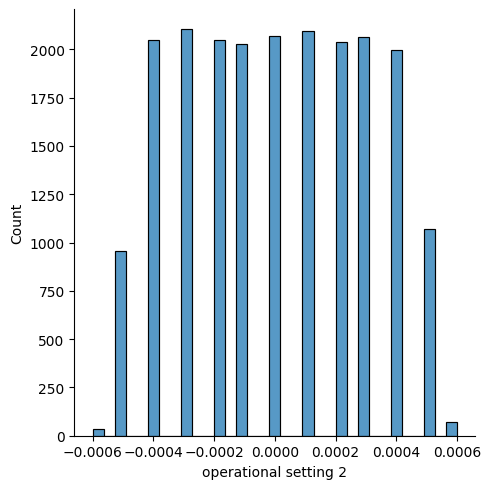

In [6]:
# X1_train["operational setting 2"].hist(bins=50)
sns.displot(X1["operational setting 2"])

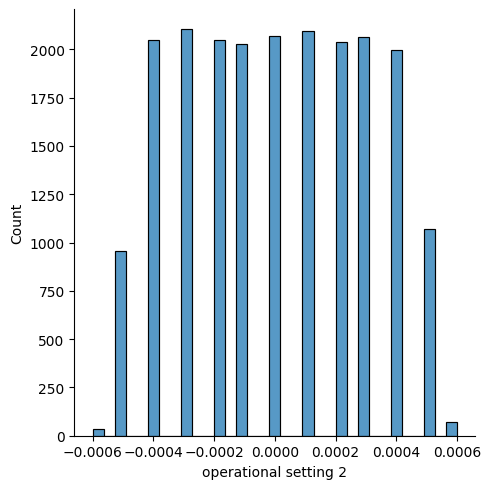

In [7]:
# X1_train["operational setting 3"].hist(bins=50)
sns.displot(X1["operational setting 2"])

#### *Sensor measurements [1 - 26]*

<AxesSubplot: >

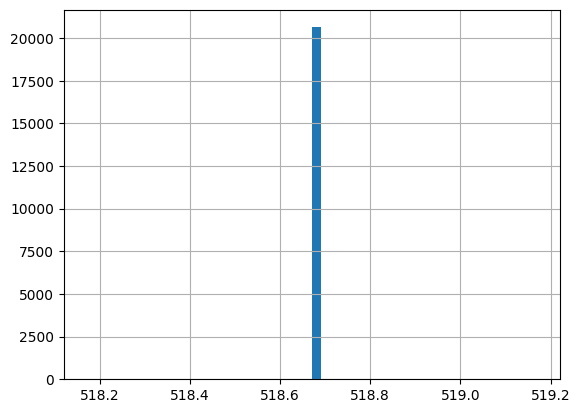

In [31]:
X1["sensor measurement 1"].hist(bins=50)
#sns.displot(X1_train["sensor measurement 1"], kind='ecdf')

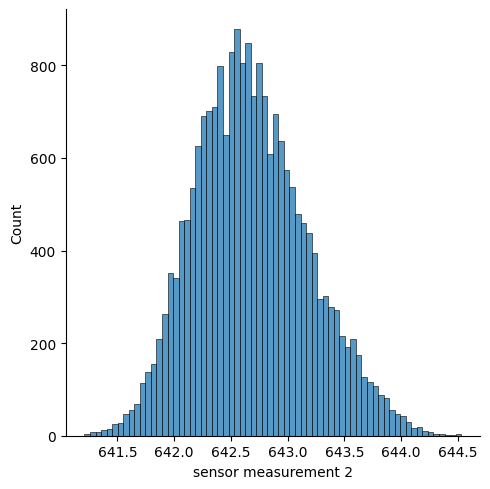

In [21]:
sns.displot(X1["sensor measurement 2"])
# X1_train["sensor measurement 2"].hist(bins=50)

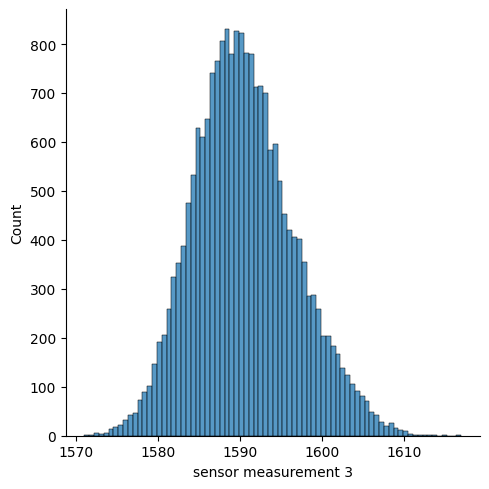

In [22]:
sns.displot(X1["sensor measurement 3"])
# X1_train["sensor measurement 3"].hist(bins=50)

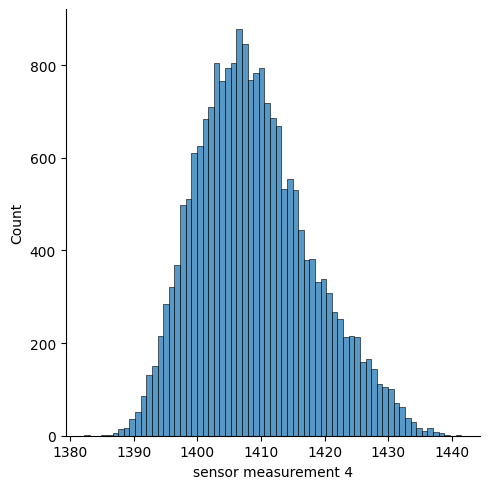

In [29]:
sns.displot(X1["sensor measurement 4"])
# X1_train["sensor measurement 4"].hist(bins=50)

<AxesSubplot: >

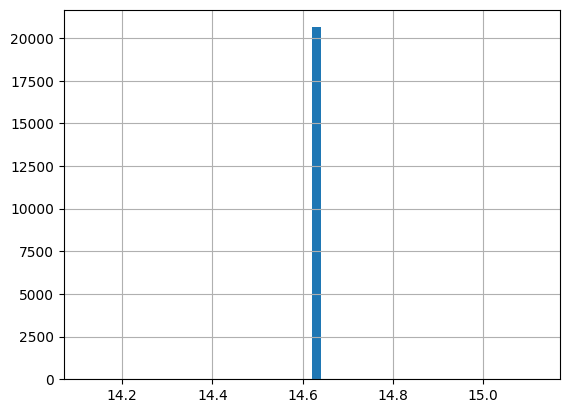

In [30]:
#sns.displot(X1_train["sensor measurement 5"], kind='ecdf')
X1["sensor measurement 5"].hist(bins=50)

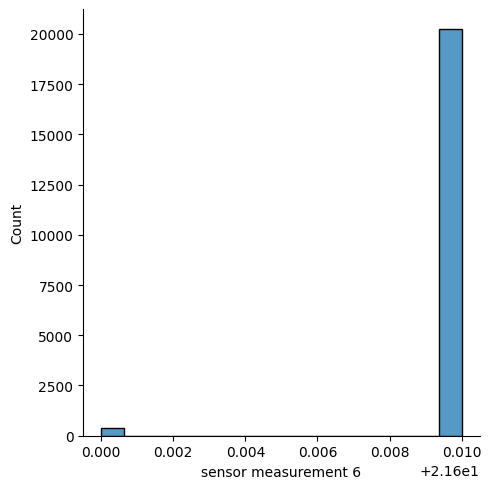

In [33]:
# X1_train["sensor measurement 6"].hist(bins=50)
sns.displot(X1["sensor measurement 6"])

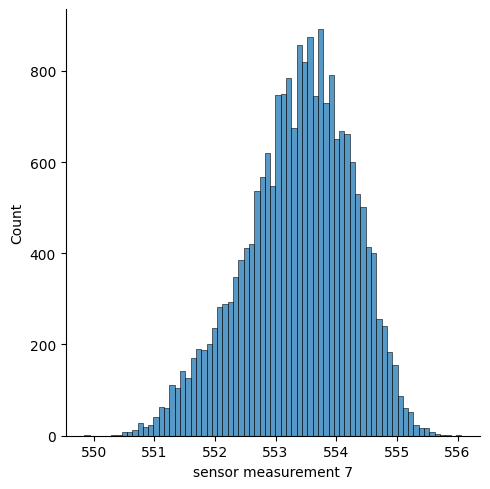

In [32]:
# X1_train["sensor measurement 7"].hist(bins=50)
sns.displot(X1["sensor measurement 7"])


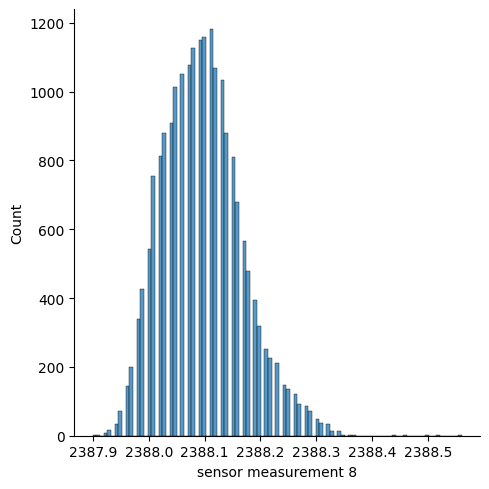

In [34]:
# X1_train["sensor measurement 8"].hist(bins=50)
sns.displot(X1["sensor measurement 8"])

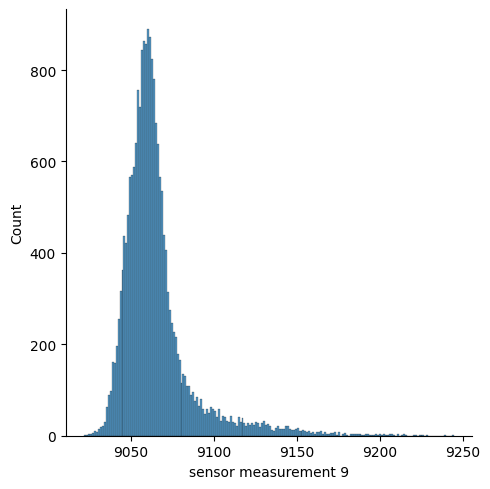

In [37]:
#X1_train["sensor measurement 9"].hist(bins=50)
sns.displot(X1["sensor measurement 9"])

<AxesSubplot: >

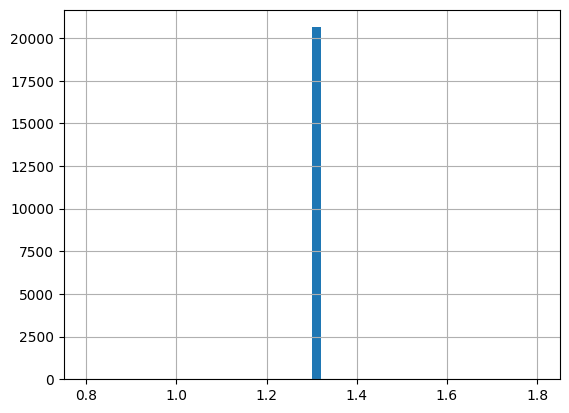

In [ ]:
X1["sensor measurement 10"].hist(bins=50)

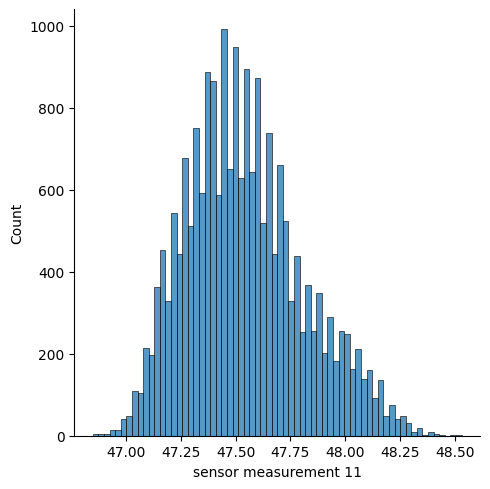

In [38]:
# X1_train["sensor measurement 11"].hist(bins=50)
sns.displot(X1["sensor measurement 11"])

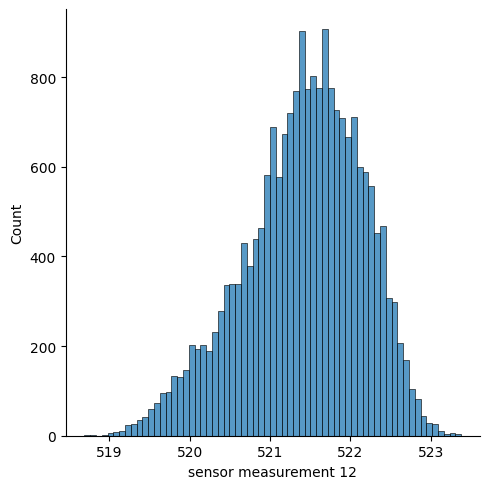

In [39]:
# X1_train["sensor measurement 12"].hist(bins=50)
sns.displot(X1["sensor measurement 12"])

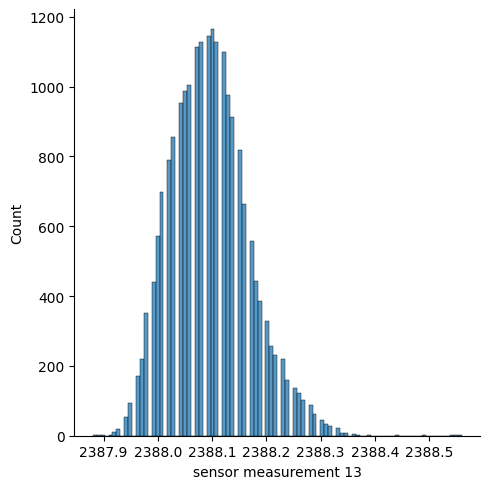

In [40]:
# X1_train["sensor measurement 13"].hist(bins=50)
sns.displot(X1["sensor measurement 13"])

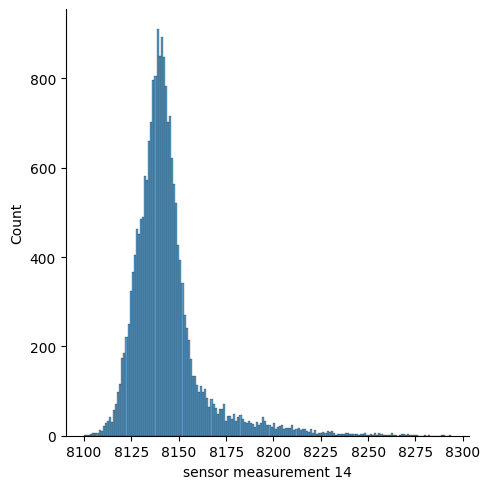

In [51]:
# X1_train["sensor measurement 14"].hist(bins=50)
sns.displot(X1["sensor measurement 14"])

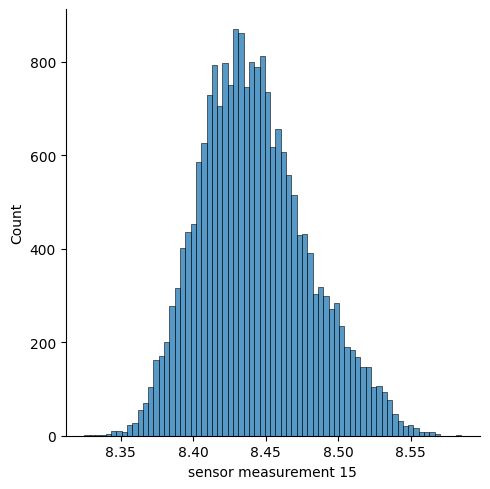

In [52]:
# X1_train["sensor measurement 15"].hist(bins=50)
sns.displot(X1["sensor measurement 15"])

<AxesSubplot: >

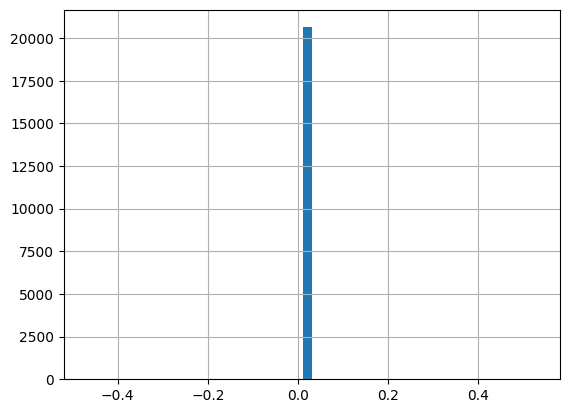

In [ ]:
X1["sensor measurement 16"].hist(bins=50)

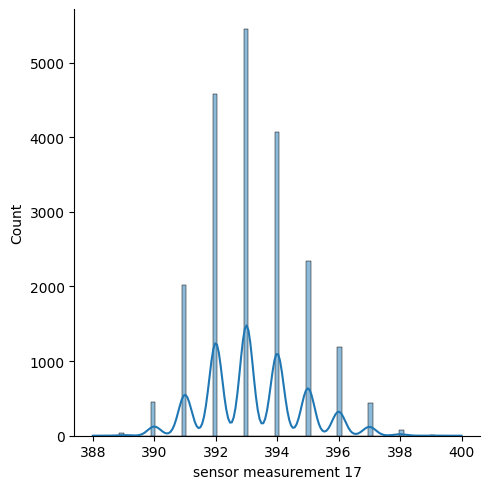

In [48]:
# X1_train["sensor measurement 17"].hist(bins=50)
sns.displot(X1["sensor measurement 17"], kde=True)

<AxesSubplot: >

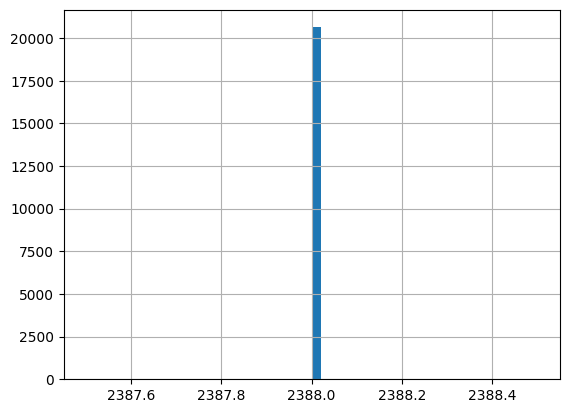

In [ ]:
X1["sensor measurement 18"].hist(bins=50)

<AxesSubplot: >

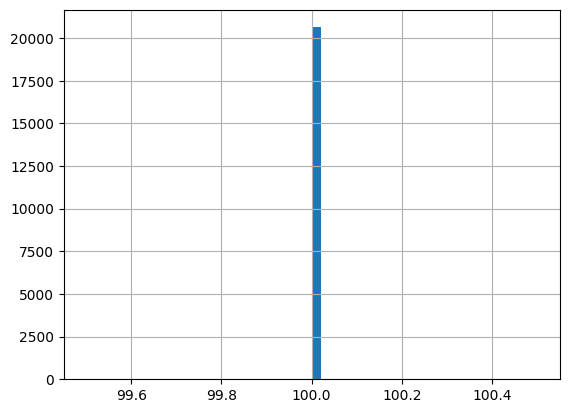

In [ ]:
X1["sensor measurement 19"].hist(bins=50)

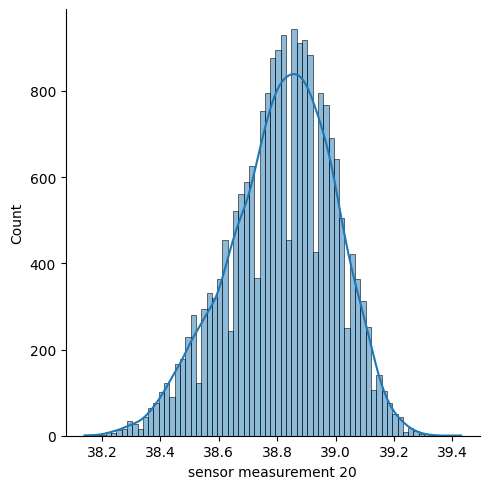

In [47]:
# X1_train["sensor measurement 20"].hist(bins=50)
sns.displot(X1["sensor measurement 20"], kde=True)

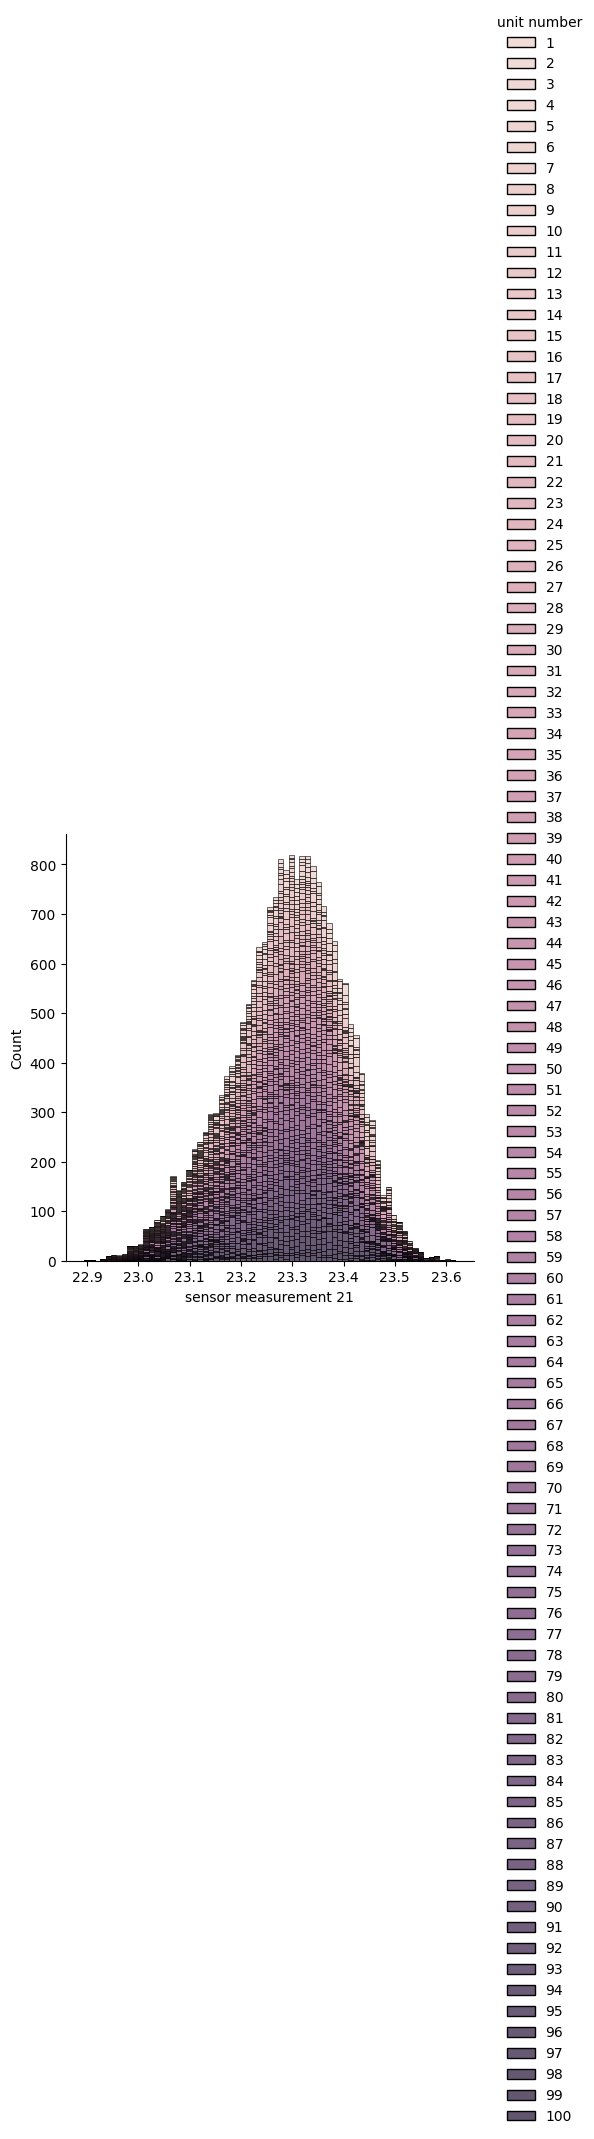

In [57]:
# X1_train["sensor measurement 21"].hist(bins=50)
sns.displot(data = X1, x = "sensor measurement 21", hue="unit number", multiple="stack")

### *Представим данные ПОКАЗАТЕЛЕЙ ДАТЧИКОВ от ВРЕМЕНИ В ЦИКЛАХ в виде графиков*

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 1'>

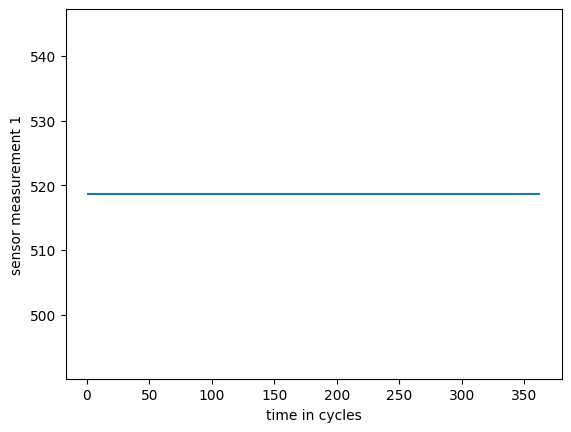

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 1", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 2'>

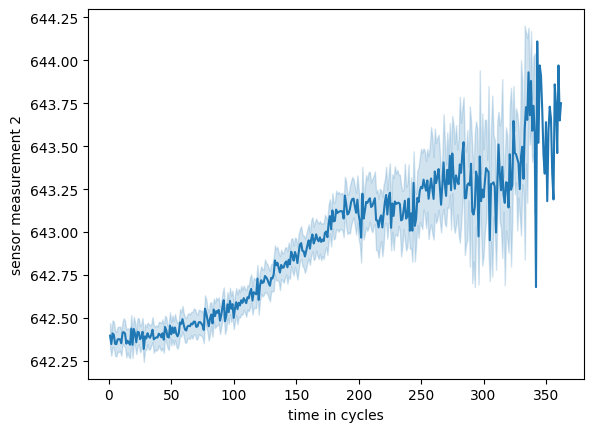

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 2", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 3'>

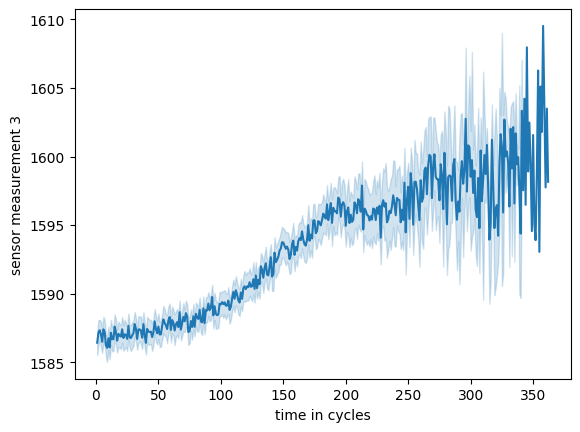

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 3", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 4'>

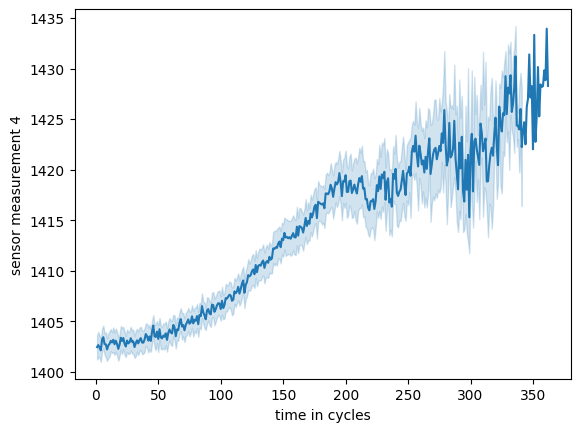

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 4", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 5'>

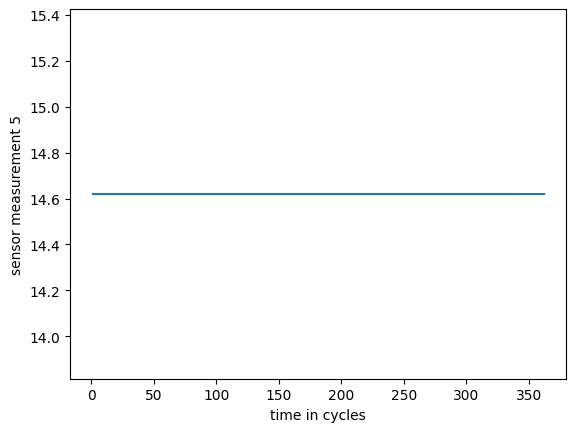

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 5", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 6'>

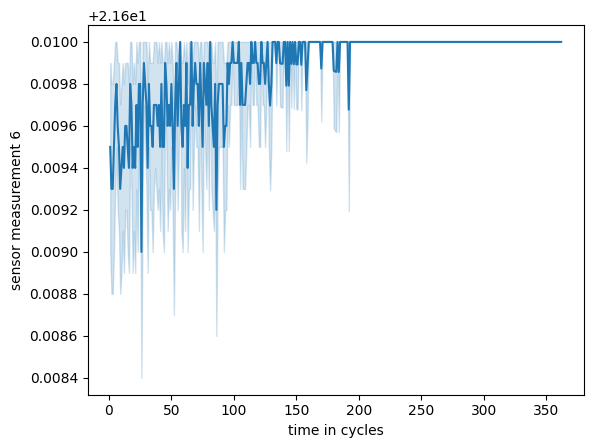

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 6", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 7'>

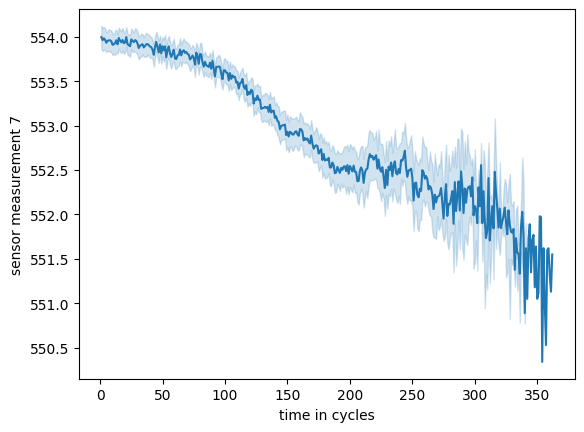

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 7", data = X1)

<AxesSubplot: xlabel='sensor measurement 8', ylabel='time in cycles'>

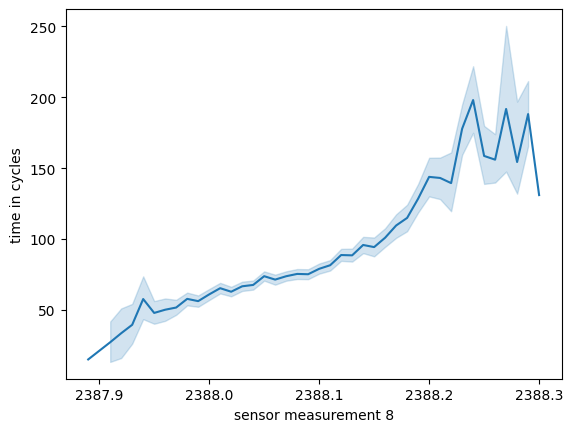

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 8", data = X1)

<AxesSubplot: xlabel='sensor measurement 9', ylabel='time in cycles'>

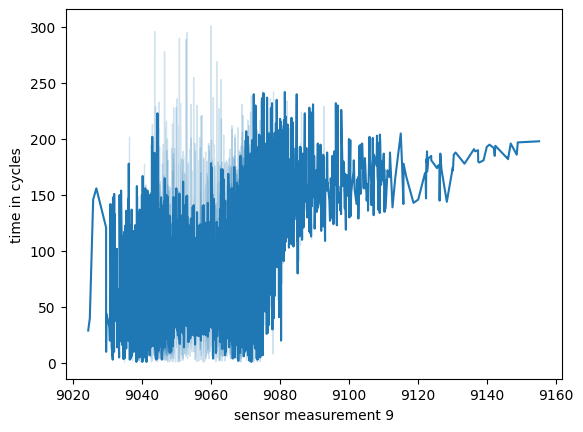

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 9", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 10'>

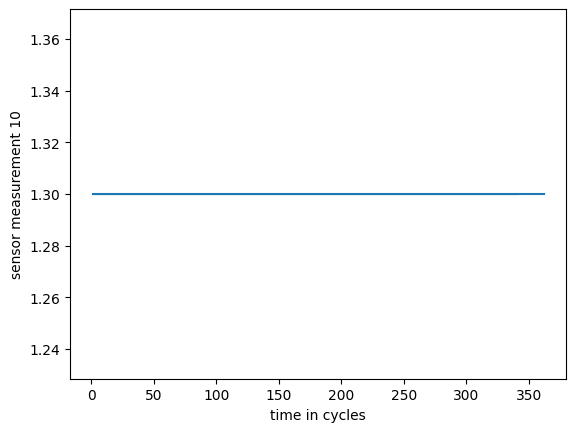

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 10", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 11'>

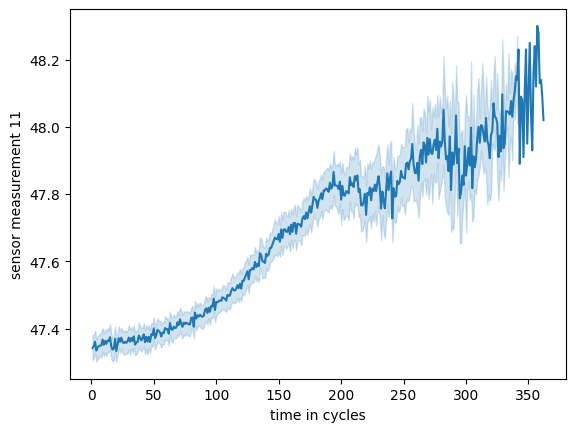

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 11", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 12'>

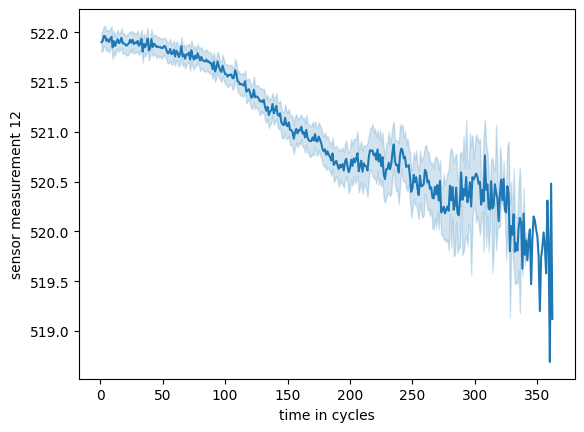

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 12", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 13'>

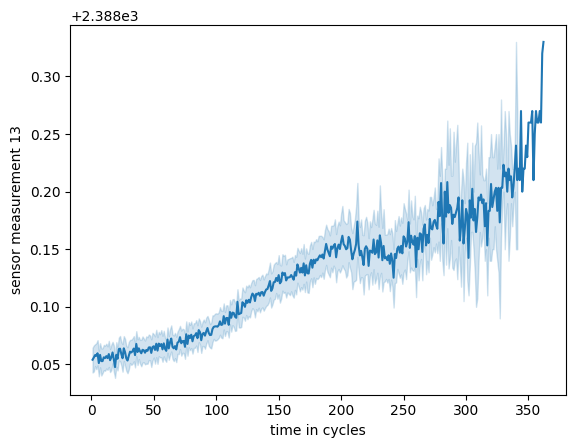

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 13", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 14'>

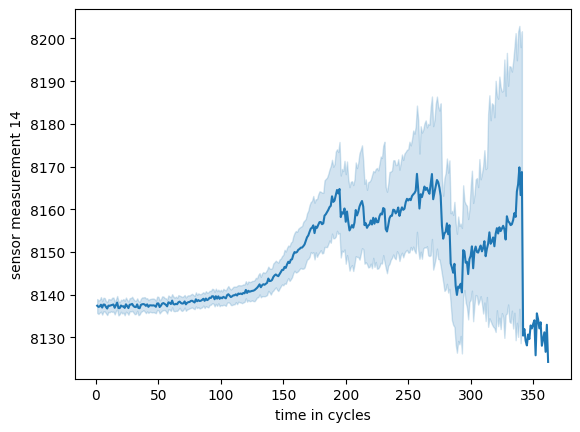

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 14", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 15'>

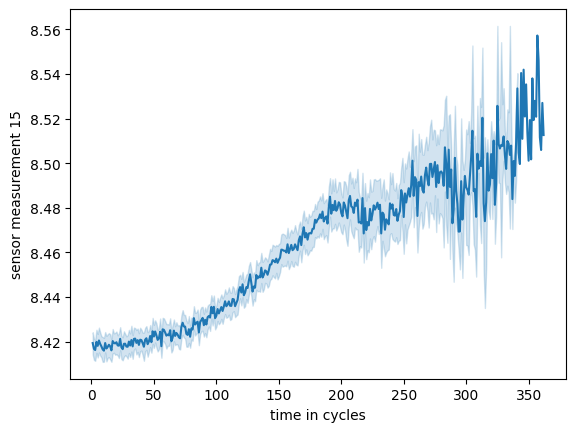

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 15", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 16'>

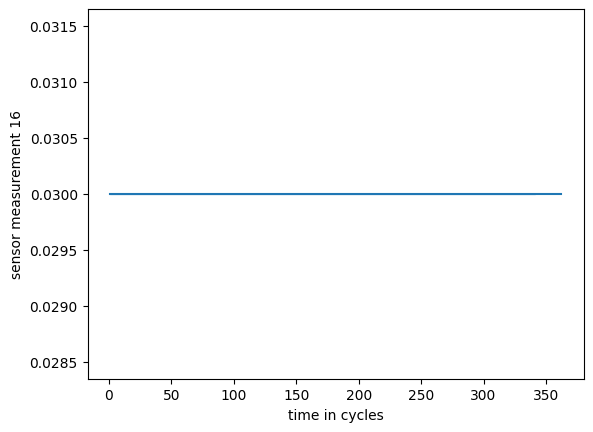

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 16", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 17'>

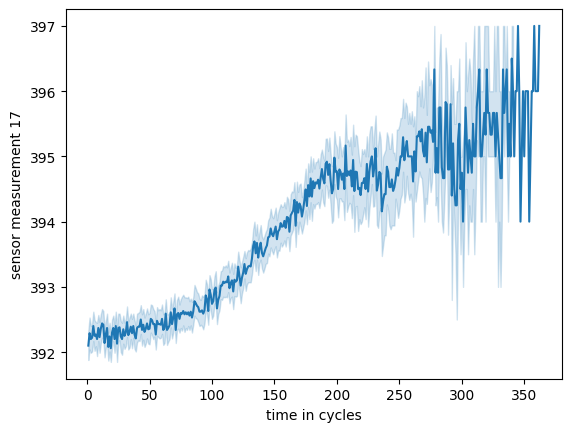

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 17", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 18'>

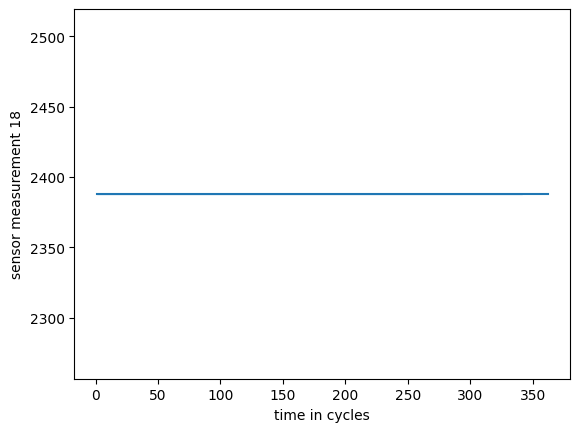

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 18", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 19'>

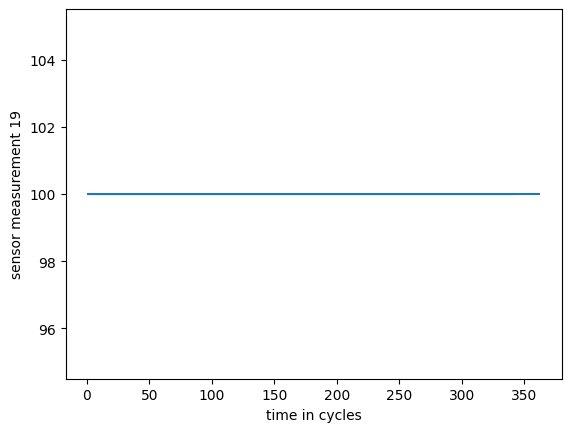

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 19", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 20'>

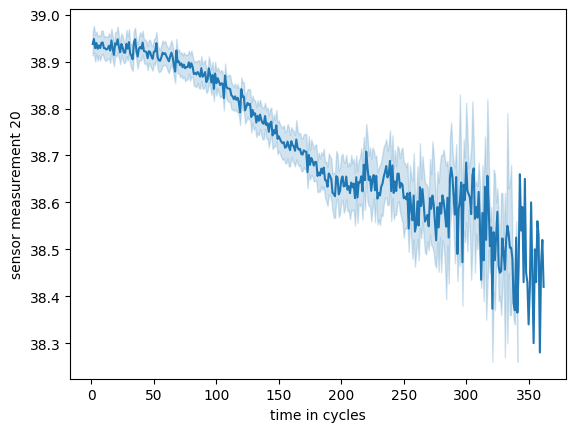

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 20", data = X1)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 21'>

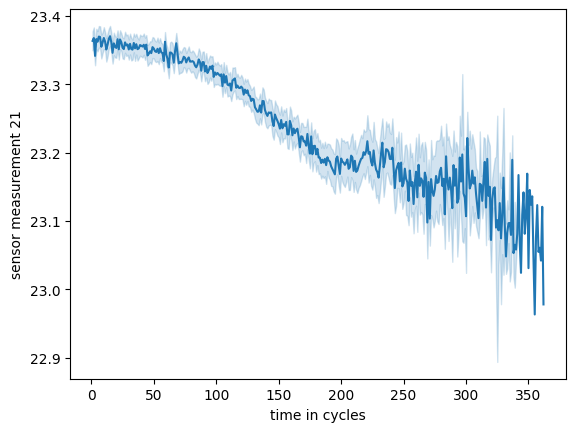

In [ ]:
sns.lineplot(x = "time in cycles", y = "sensor measurement 21", data = X1)

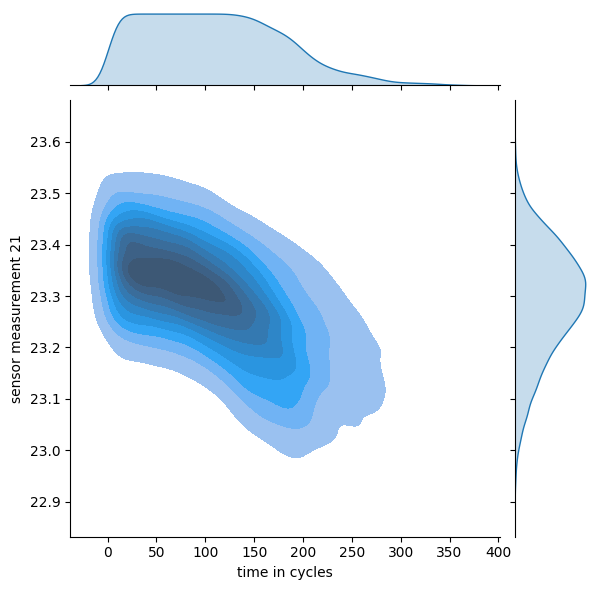

In [5]:
sns.jointplot(
    x = "time in cycles",
    y = "sensor measurement 21",
    data = X1,
    kind = 'kde',
    fill = True
)

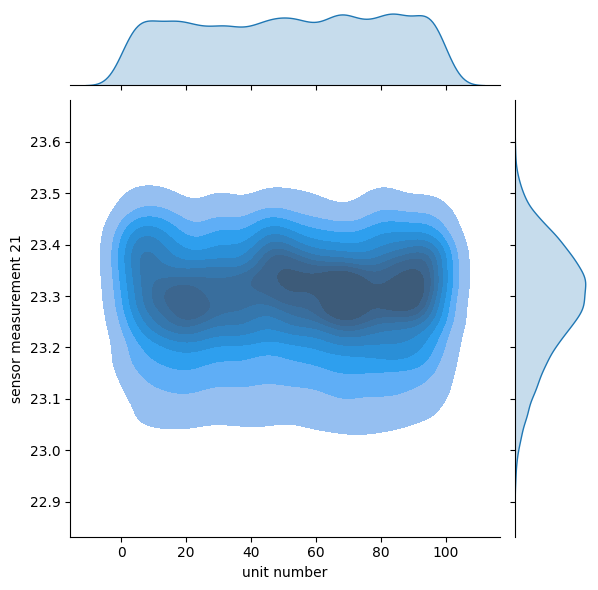

In [6]:
sns.jointplot(
    x = "unit number",
    y = "sensor measurement 21",
    data = X1,
    kind = 'kde',
    fill = True
)

## *Предобработка данных*

In [7]:
from sklearn import preprocessing

In [40]:
X1

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [41]:
X1_st = preprocessing.StandardScaler().fit(X1)
X1_st = X1_st.transform(X1)

X1_st = pd.DataFrame(X1_st)
X1_st.columns = ['unit number', 'time in cycles', 'operational setting 1', 'operational setting 2', 'operational setting 3', 'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11', 'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14', 'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17', 'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20', 'sensor measurement 21']

In [42]:
X1_st

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,-1.728084,-1.565170,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,...,0.334262,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427
1,-1.728084,-1.550652,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,1.174899,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922
2,-1.728084,-1.536134,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,1.364721,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423
3,-1.728084,-1.521616,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,1.961302,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792
4,-1.728084,-1.507098,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,1.052871,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.659204,1.265868,-0.178822,-1.031720,0.0,0.0,1.618000,1.216258,2.188375,-1.776357e-15,...,-2.607969,2.278282,-0.322542,1.425294,-1.387779e-17,2.446751,0.0,0.0,-1.805173,-2.921113
20627,1.659204,1.280386,-0.727453,-1.714186,0.0,0.0,1.717992,2.279706,2.738351,-1.776357e-15,...,-2.350355,1.722087,-0.380207,1.913240,-1.387779e-17,1.155367,0.0,0.0,-2.856395,-1.203764
20628,1.659204,1.294904,0.186933,-0.008022,0.0,0.0,1.478011,1.946971,2.138377,-1.776357e-15,...,-1.902919,2.000184,-0.141684,3.265092,-1.387779e-17,3.092444,0.0,0.0,-2.081810,-3.292481
20629,1.659204,1.309423,-0.498857,1.015677,0.0,0.0,1.098043,2.403666,1.955051,-1.776357e-15,...,-2.363913,1.861136,-0.233948,2.579834,-1.387779e-17,1.155367,0.0,0.0,-2.911722,-2.085072


#### *Посмотрим на графики*

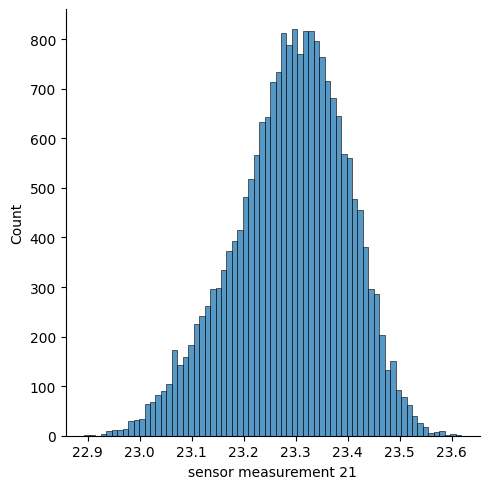

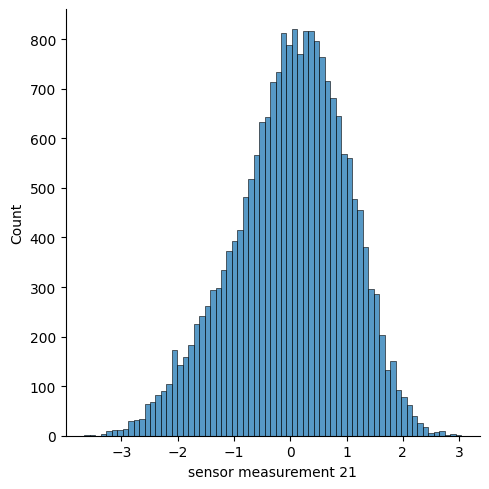

In [11]:
sns.displot(X1["sensor measurement 21"])
sns.displot(X1_st["sensor measurement 21"])

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 21'>

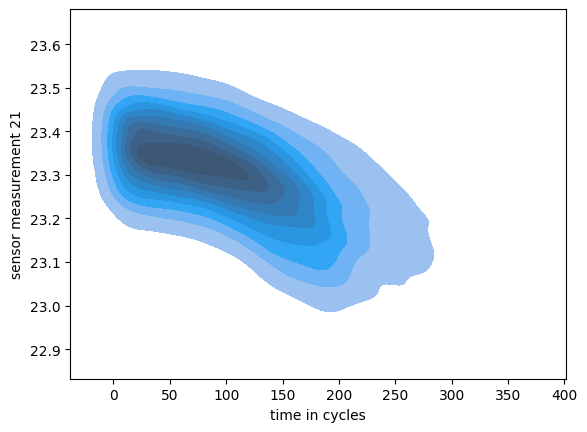

In [13]:
sns.kdeplot(data=X1, x="time in cycles", y="sensor measurement 21", fill = True)

<AxesSubplot: xlabel='time in cycles', ylabel='sensor measurement 21'>

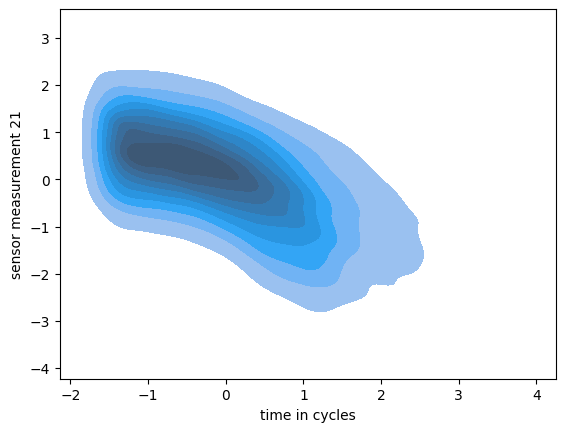

In [14]:
sns.kdeplot(data=X1_st, x="time in cycles", y="sensor measurement 21", fill = True)

#### *Столбцы UNIT NUMBER и TIME IN CYCLES по сути не влияют на оценку поломки двигателей, поэтому их можно удалить.*

In [43]:
X1_st.drop(columns = X1_st.columns[0], axis= 1 , inplace= True)
X1_st.drop(columns = X1_st.columns[0], axis= 1 , inplace= True)

In [44]:
X1_st

,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,sensor measurement 6,sensor measurement 7,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,0.141683,1.121141,...,0.334262,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427
1,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,0.141683,0.431930,...,1.174899,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922
2,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,0.141683,1.008155,...,1.364721,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423
3,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,0.141683,1.222827,...,1.961302,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792
4,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,0.141683,0.714393,...,1.052871,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.178822,-1.031720,0.0,0.0,1.618000,1.216258,2.188375,-1.776357e-15,0.141683,-2.189329,...,-2.607969,2.278282,-0.322542,1.425294,-1.387779e-17,2.446751,0.0,0.0,-1.805173,-2.921113
20627,-0.727453,-1.714186,0.0,0.0,1.717992,2.279706,2.738351,-1.776357e-15,0.141683,-2.833345,...,-2.350355,1.722087,-0.380207,1.913240,-1.387779e-17,1.155367,0.0,0.0,-2.856395,-1.203764
20628,0.186933,-0.008022,0.0,0.0,1.478011,1.946971,2.138377,-1.776357e-15,0.141683,-2.742957,...,-1.902919,2.000184,-0.141684,3.265092,-1.387779e-17,3.092444,0.0,0.0,-2.081810,-3.292481
20629,-0.498857,1.015677,0.0,0.0,1.098043,2.403666,1.955051,-1.776357e-15,0.141683,-3.036719,...,-2.363913,1.861136,-0.233948,2.579834,-1.387779e-17,1.155367,0.0,0.0,-2.911722,-2.085072


#### *Разделим датасет на Train и Test выборки.*
*Аномальными значениями считаем 10 последних показателей для каждого UNIT NUMBER в датасете  Х1.*

#### *Добавим Validate выборку из X2, без аномальных значений*

In [45]:
X2

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


In [48]:
X2_st = preprocessing.StandardScaler().fit(X2)
X2_st = X2_st.transform(X2)

X2_st = pd.DataFrame(X2_st)
X2_st.columns = ['unit number', 'time in cycles', 'operational setting 1', 'operational setting 2', 'operational setting 3', 'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11', 'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14', 'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17', 'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20', 'sensor measurement 21']

X2_st.drop(columns = X2_st.columns[0], axis= 1 , inplace= True)
X2_st.drop(columns = X2_st.columns[0], axis= 1 , inplace= True)

In [49]:
X2_st

,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,sensor measurement 6,sensor measurement 7,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,0.745895,0.864298,0.418187,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,-0.662907,-0.602496,...,-0.603008,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148
1,1.220553,0.866878,0.418187,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,-1.084502,-0.986938,...,-0.985404,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190
2,0.067836,0.160457,-2.391275,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,-0.475122,-0.732150,...,-0.739869,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912
3,1.221198,0.869459,0.418187,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,-1.084502,-0.987280,...,-0.983225,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808
4,0.067951,0.155618,-2.391275,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,-0.473281,-0.736670,...,-0.739215,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,-0.270878,0.412704,0.418187,0.692693,0.780862,0.713849,0.537834,0.364716,0.379114,0.351999,...,0.348551,0.425267,1.214589,-0.034903,1.416565,0.745489,0.655032,0.418187,0.361801,0.345429
53755,-0.949073,-1.035622,0.418187,0.611600,0.700946,0.890544,0.996270,0.688475,0.717863,0.752399,...,0.763855,0.420582,2.107123,-0.762087,1.416565,0.925641,0.620627,0.418187,0.740757,0.755203
53756,0.068195,0.154650,-2.391275,-0.392968,-1.131496,-1.356652,-1.238408,-0.271732,-0.471440,-0.736259,...,-0.743356,-2.375530,-1.123891,2.316803,-0.705933,-1.380311,-2.159318,-2.391275,-0.668673,-0.662515
53757,0.068141,0.161102,-2.391275,-0.392968,-1.121841,-1.387706,-1.168060,-0.271732,-0.471440,-0.738314,...,-0.738779,-2.375374,-1.109510,2.300789,-0.705933,-1.344281,-2.159318,-2.391275,-0.682859,-0.692473


### *Этап 4 - Построение модели автокодировщика*

In [50]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [51]:
input_dim = len(X1_st.columns)


autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(18, activation='elu'),
    tf.keras.layers.Dense(12, activation='elu'),
    tf.keras.layers.Dense(6, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(6, activation='elu'),
    tf.keras.layers.Dense(12, activation='elu'),
    tf.keras.layers.Dense(18, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
])


autoencoder.compile(optimizer = "adam", 
                    loss = "mse",
                    metrics = ["acc"])


autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 24)                600       
                                                                 
 dense_55 (Dense)            (None, 18)                450       
                                                                 
 dense_56 (Dense)            (None, 12)                228       
                                                                 
 dense_57 (Dense)            (None, 6)                 78        
                                                                 
 dense_58 (Dense)            (None, 2)                 14        
                                                                 
 dense_59 (Dense)            (None, 6)                 18        
                                                                 
 dense_60 (Dense)            (None, 12)               

In [52]:
import datetime


log_dir = "content/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch = (10,100)
)

### *Этап 5 - Обучение модели*

In [ ]:
# tensorboard --logdir content/logs/

In [54]:
# autoencoder.fit(X1_train_st, validation_data=X1_train_st, epochs=230, callbacks=[tensorboard_callback])

history = autoencoder.fit(
    X1_st, X1_st,
    shuffle = True,
    epochs = 150,
    batch_size = 200,
    callbacks = [tensorboard_callback],
    validation_data=(X2_st, X2_st)
);

Epoch 1/150
104/104 [==============================] - 3s 26ms/step - loss: 0.2092 - acc: 0.3339 - val_loss: 1.2897 - val_acc: 0.1509
Epoch 2/150
104/104 [==============================] - 2s 23ms/step - loss: 0.2091 - acc: 0.3344 - val_loss: 1.2724 - val_acc: 0.1506
Epoch 3/150
104/104 [==============================] - 2s 23ms/step - loss: 0.2093 - acc: 0.3338 - val_loss: 1.2455 - val_acc: 0.1502
Epoch 4/150
104/104 [==============================] - 2s 23ms/step - loss: 0.2090 - acc: 0.3315 - val_loss: 1.2617 - val_acc: 0.1505
Epoch 5/150
104/104 [==============================] - 2s 22ms/step - loss: 0.2088 - acc: 0.3344 - val_loss: 1.2798 - val_acc: 0.1501
Epoch 6/150
104/104 [==============================] - 2s 21ms/step - loss: 0.2088 - acc: 0.3338 - val_loss: 1.2778 - val_acc: 0.1507
Epoch 7/150
104/104 [==============================] - 2s 21ms/step - loss: 0.2088 - acc: 0.3367 - val_loss: 1.2553 - val_acc: 0.1499
Epoch 8/150
104/104 [==============================] - 2s 21ms

### *Этап 6 - Применение модели, проверка модели на обобщенность*